# 20. Conditional Expectation

**Goal:** Understand conditional expectation as an $L^2$ projection, verify the tower property,
and visualize $E[X \mid Y]$ as a smoothing operation on the joint distribution.

**Key Idea:** Given random variables $X$ and $Y$, the conditional expectation $E[X \mid Y]$ is
the $\sigma(Y)$-measurable function $g(Y)$ that minimizes the mean squared error
$E[(X - g(Y))^2]$. This is precisely the orthogonal projection of $X$ onto the closed
subspace of $\sigma(Y)$-measurable $L^2$ functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Conditional Expectation as $L^2$ Projection

Among all functions $g(Y)$, the conditional expectation $E[X \mid Y]$ is the unique
(a.s.) minimizer of $E[(X - g(Y))^2]$.

**Analogy:** Just as in Euclidean geometry, the closest point on a subspace to a given
point is found by orthogonal projection, $E[X \mid Y]$ is the "closest" $\sigma(Y)$-measurable
approximation to $X$ in the $L^2$ sense.

We demonstrate this with a bivariate normal $(X, Y)$ where
$E[X \mid Y] = \mu_X + \rho \frac{\sigma_X}{\sigma_Y}(Y - \mu_Y)$.

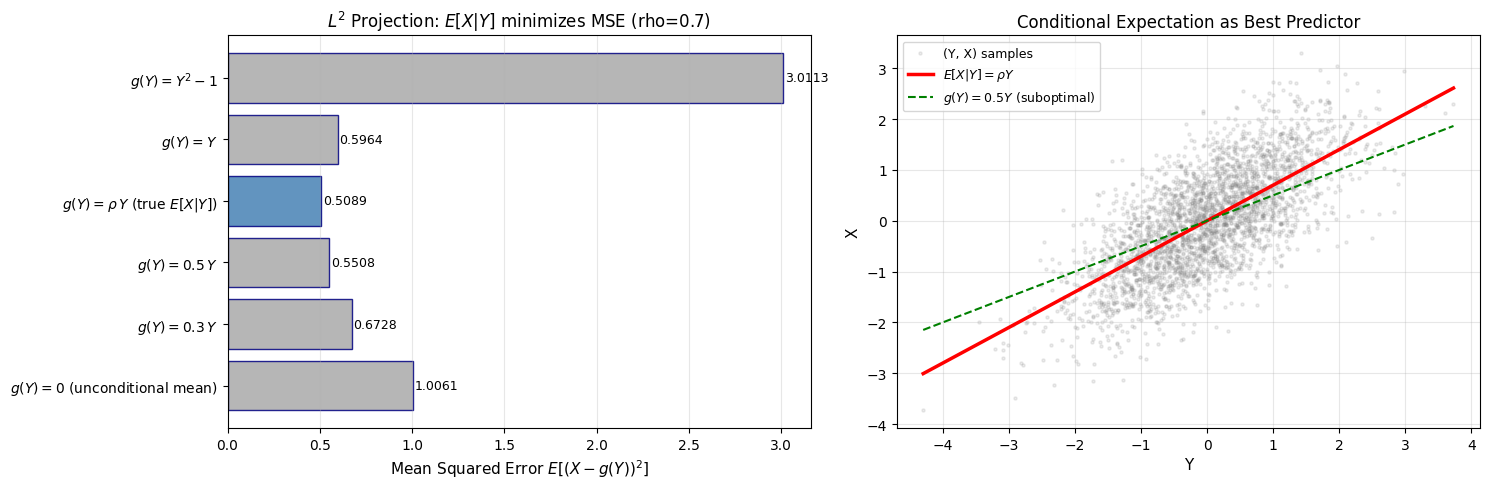

Minimum MSE achieved by E[X|Y]: 0.508914
Theoretical residual variance: 1 - rho^2 = 0.510000


In [2]:
np.random.seed(42)
n = 100_000
rho = 0.7

# Generate bivariate normal (X, Y) with correlation rho
Z1 = np.random.standard_normal(n)
Z2 = np.random.standard_normal(n)
Y = Z1
X = rho * Z1 + np.sqrt(1 - rho**2) * Z2  # X = rho*Y + sqrt(1-rho^2)*Z2

# True conditional expectation: E[X|Y] = rho * Y
cond_exp_true = rho * Y

# Compare MSE: E[X|Y] vs other candidate functions g(Y)
candidates = {
    r'$g(Y) = 0$ (unconditional mean)': np.zeros(n),
    r'$g(Y) = 0.3\,Y$': 0.3 * Y,
    r'$g(Y) = 0.5\,Y$': 0.5 * Y,
    r'$g(Y) = \rho\,Y$ (true $E[X|Y]$)': cond_exp_true,
    r'$g(Y) = Y$': Y,
    r'$g(Y) = Y^2 - 1$': Y**2 - 1,
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart of MSE for each candidate
names = list(candidates.keys())
mses = [np.mean((X - g)**2) for g in candidates.values()]
colors = ['#aaa'] * len(names)
colors[3] = 'steelblue'  # highlight the true CE
ax1.barh(range(len(names)), mses, color=colors, edgecolor='navy', alpha=0.85)
ax1.set_yticks(range(len(names)))
ax1.set_yticklabels(names, fontsize=10)
ax1.set_xlabel('Mean Squared Error $E[(X - g(Y))^2]$', fontsize=11)
ax1.set_title(f'$L^2$ Projection: $E[X|Y]$ minimizes MSE (rho={rho})', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(mses):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

# Scatter plot with conditional expectation line
idx = np.random.choice(n, 3000, replace=False)
ax2.scatter(Y[idx], X[idx], alpha=0.15, s=5, color='gray', label='(Y, X) samples')
y_sorted = np.sort(Y[idx])
ax2.plot(y_sorted, rho * y_sorted, 'r-', linewidth=2.5, label=r'$E[X|Y] = \rho Y$')
ax2.plot(y_sorted, 0.5 * y_sorted, 'g--', linewidth=1.5, label=r'$g(Y) = 0.5Y$ (suboptimal)')
ax2.set_xlabel('Y', fontsize=11)
ax2.set_ylabel('X', fontsize=11)
ax2.set_title('Conditional Expectation as Best Predictor', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Minimum MSE achieved by E[X|Y]: {mses[3]:.6f}')
print(f'Theoretical residual variance: 1 - rho^2 = {1 - rho**2:.6f}')

## Computing $E[X \mid Y]$: Discrete Case

When $Y$ takes finitely many values $\{y_1, \ldots, y_k\}$, the conditional expectation
is simply the mean of $X$ within each level set:

$$E[X \mid Y = y_j] = \frac{E[X \cdot \mathbf{1}_{\{Y=y_j\}}]}{P(Y=y_j)}$$

We simulate a joint distribution on $(X, Y)$ where $Y \in \{1, 2, 3, 4\}$
and $X \mid Y=y \sim N(y^2, 1)$.

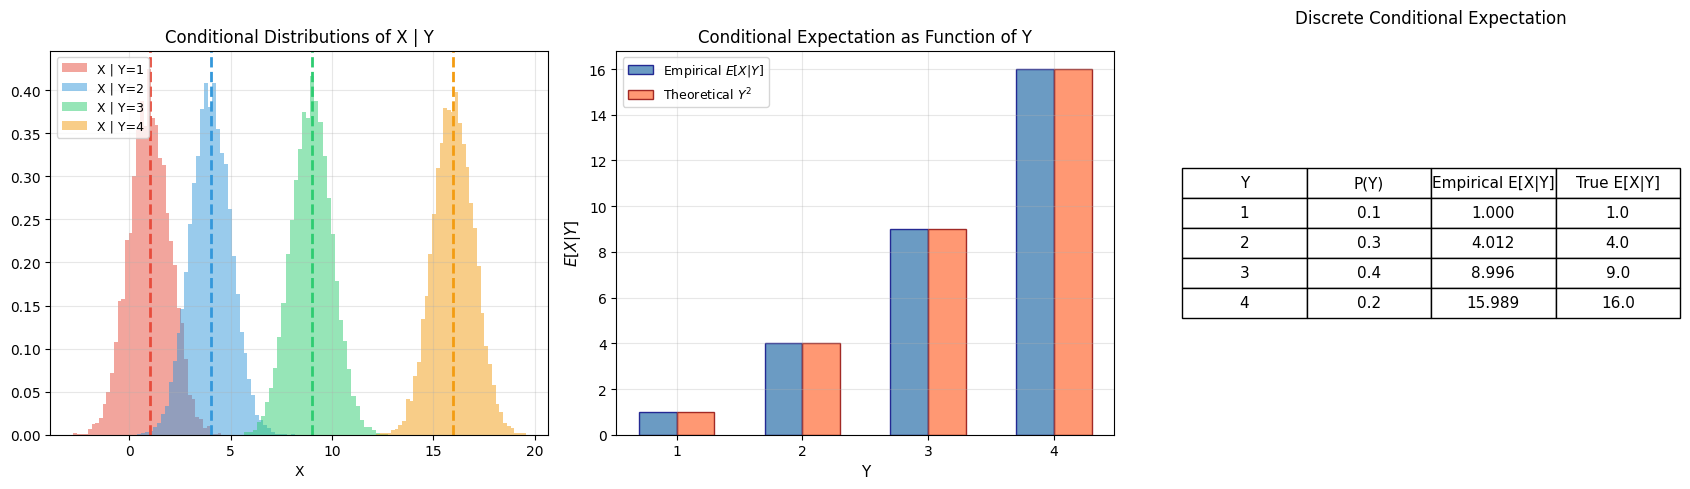

In [3]:
np.random.seed(123)
n = 50_000

# Discrete Y, continuous X|Y
Y_vals = np.array([1, 2, 3, 4])
Y_disc = np.random.choice(Y_vals, size=n, p=[0.1, 0.3, 0.4, 0.2])
X_disc = np.random.normal(loc=Y_disc**2, scale=1.0)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: Conditional distributions
ax = axes[0]
colors_disc = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, y in enumerate(Y_vals):
    mask = Y_disc == y
    ax.hist(X_disc[mask], bins=40, density=True, alpha=0.5,
            color=colors_disc[i], label=f'X | Y={y}')
    emp_mean = np.mean(X_disc[mask])
    ax.axvline(emp_mean, color=colors_disc[i], linestyle='--', linewidth=2)
ax.set_title('Conditional Distributions of X | Y', fontsize=12)
ax.set_xlabel('X')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: E[X|Y] as a function of Y
ax = axes[1]
empirical_ce = np.array([np.mean(X_disc[Y_disc == y]) for y in Y_vals])
theoretical_ce = Y_vals**2
ax.bar(Y_vals - 0.15, empirical_ce, width=0.3, color='steelblue',
       edgecolor='navy', alpha=0.8, label='Empirical $E[X|Y]$')
ax.bar(Y_vals + 0.15, theoretical_ce, width=0.3, color='coral',
       edgecolor='darkred', alpha=0.8, label='Theoretical $Y^2$')
ax.set_xlabel('Y', fontsize=11)
ax.set_ylabel('$E[X | Y]$', fontsize=11)
ax.set_title('Conditional Expectation as Function of Y', fontsize=12)
ax.set_xticks(Y_vals)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: Verification table
ax = axes[2]
ax.axis('off')
p_y = np.array([0.1, 0.3, 0.4, 0.2])
table_data = []
for i, y in enumerate(Y_vals):
    table_data.append([f'{y}', f'{p_y[i]:.1f}',
                       f'{empirical_ce[i]:.3f}', f'{theoretical_ce[i]:.1f}'])
table = ax.table(cellText=table_data,
                 colLabels=['Y', 'P(Y)', 'Empirical E[X|Y]', 'True E[X|Y]'],
                 cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.8)
ax.set_title('Discrete Conditional Expectation', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

## Computing $E[X \mid Y]$: Continuous Case (Binning Estimator)

When both $X$ and $Y$ are continuous, we estimate $E[X \mid Y = y]$ by partitioning
the range of $Y$ into bins and averaging $X$ within each bin. As the bin width
shrinks (and sample size grows), this converges to the true conditional expectation.

We use a nonlinear relationship: $X = \sin(2Y) + 0.5\,\varepsilon$ to show that
conditional expectation captures the nonlinear signal.

<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/var/folders/22/xxwj0_711b34fsf64tkzj_ph0000gn/T/ipykernel_48518/1143107469.py:68: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathrm{Var}(X \mid Y)$', fontsize=11)


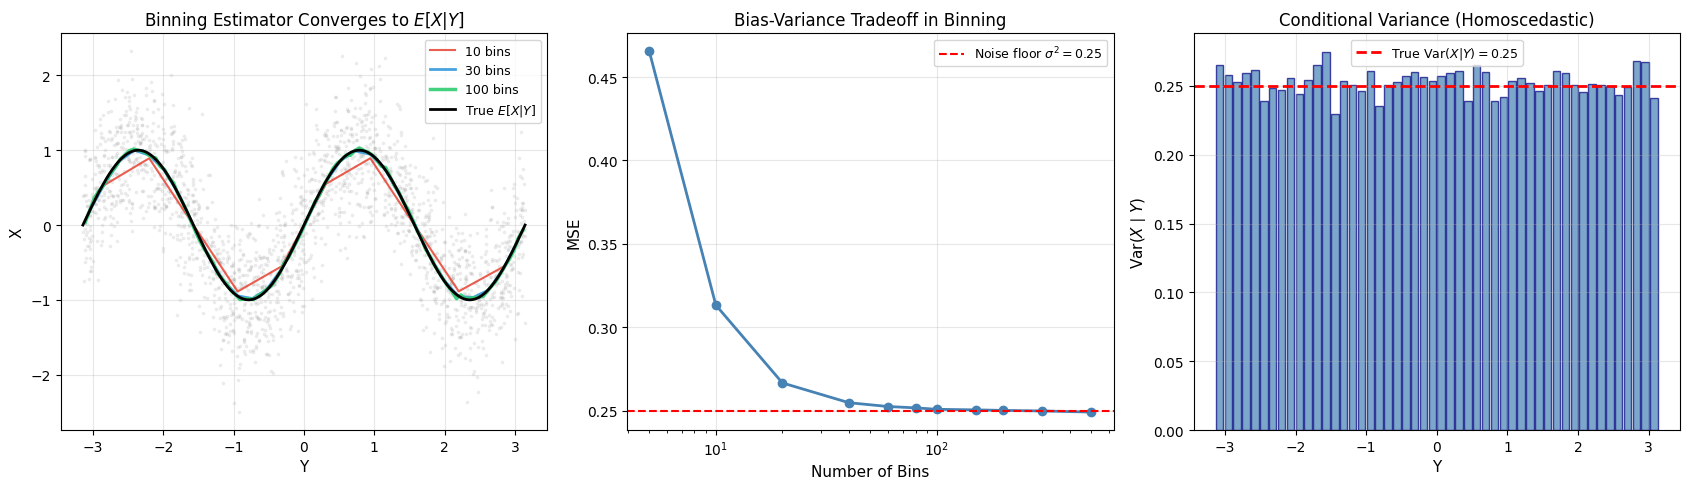

In [4]:
np.random.seed(777)
n = 80_000

Y_cont = np.random.uniform(-np.pi, np.pi, n)
noise = np.random.standard_normal(n)
X_cont = np.sin(2 * Y_cont) + 0.5 * noise  # nonlinear relationship

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: Different bin resolutions
ax = axes[0]
idx_plot = np.random.choice(n, 2000, replace=False)
ax.scatter(Y_cont[idx_plot], X_cont[idx_plot], alpha=0.1, s=3, color='gray')

for n_bins, color, lw in [(10, '#e74c3c', 1.5), (30, '#3498db', 2.0), (100, '#2ecc71', 2.5)]:
    bin_edges = np.linspace(-np.pi, np.pi, n_bins + 1)
    bin_idx = np.digitize(Y_cont, bin_edges) - 1
    bin_idx = np.clip(bin_idx, 0, n_bins - 1)
    bin_means = np.array([np.mean(X_cont[bin_idx == b]) if np.sum(bin_idx == b) > 0
                          else 0 for b in range(n_bins)])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, bin_means, color=color, linewidth=lw,
            label=f'{n_bins} bins', alpha=0.9)

y_grid = np.linspace(-np.pi, np.pi, 300)
ax.plot(y_grid, np.sin(2 * y_grid), 'k-', linewidth=2, label='True $E[X|Y]$')
ax.set_xlabel('Y', fontsize=11)
ax.set_ylabel('X', fontsize=11)
ax.set_title('Binning Estimator Converges to $E[X|Y]$', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: MSE vs number of bins (bias-variance tradeoff)
ax = axes[1]
bin_counts = [5, 10, 20, 40, 60, 80, 100, 150, 200, 300, 500]
mse_bins = []
for nb in bin_counts:
    edges = np.linspace(-np.pi, np.pi, nb + 1)
    bidx = np.clip(np.digitize(Y_cont, edges) - 1, 0, nb - 1)
    bmeans = np.array([np.mean(X_cont[bidx == b]) if np.sum(bidx == b) > 0
                       else 0 for b in range(nb)])
    predicted = bmeans[bidx]
    mse_bins.append(np.mean((X_cont - predicted)**2))

ax.semilogx(bin_counts, mse_bins, 'o-', color='steelblue', linewidth=2, markersize=6)
ax.axhline(0.25, color='red', linestyle='--', linewidth=1.5,
           label=r'Noise floor $\sigma^2 = 0.25$')
ax.set_xlabel('Number of Bins', fontsize=11)
ax.set_ylabel('MSE', fontsize=11)
ax.set_title('Bias-Variance Tradeoff in Binning', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: Conditional variance
ax = axes[2]
n_bins_cv = 50
edges_cv = np.linspace(-np.pi, np.pi, n_bins_cv + 1)
bidx_cv = np.clip(np.digitize(Y_cont, edges_cv) - 1, 0, n_bins_cv - 1)
bin_vars = np.array([np.var(X_cont[bidx_cv == b]) if np.sum(bidx_cv == b) > 5
                     else np.nan for b in range(n_bins_cv)])
bin_ctrs = (edges_cv[:-1] + edges_cv[1:]) / 2
valid = ~np.isnan(bin_vars)
ax.bar(bin_ctrs[valid], bin_vars[valid], width=2*np.pi/n_bins_cv * 0.85,
       color='steelblue', edgecolor='navy', alpha=0.7)
ax.axhline(0.25, color='red', linestyle='--', linewidth=2,
           label=r'True $\mathrm{Var}(X|Y) = 0.25$')
ax.set_xlabel('Y', fontsize=11)
ax.set_ylabel('$\mathrm{Var}(X \mid Y)$', fontsize=11)
ax.set_title('Conditional Variance (Homoscedastic)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## The Tower Property: $E[E[X \mid Y]] = E[X]$

The tower property (law of iterated expectations) states that taking the
outer expectation of a conditional expectation recovers the unconditional mean.
More generally, if $\mathcal{G} \subseteq \mathcal{H}$, then
$E[E[X \mid \mathcal{H}] \mid \mathcal{G}] = E[X \mid \mathcal{G}]$.

We verify this numerically across several joint distributions.

/Users/mengren/opt/anaconda3/envs/torch/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mengren/opt/anaconda3/envs/torch/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


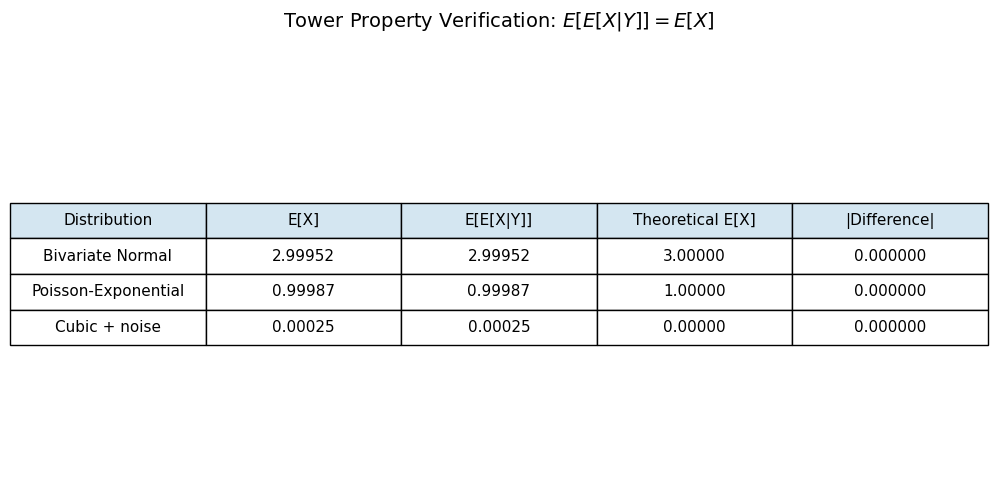

Tower property verified: E[E[X|Y]] matches E[X] up to sampling error.


In [5]:
np.random.seed(999)
n = 200_000

# --- Test 1: Bivariate normal ---
rho_t = 0.6
Z1 = np.random.standard_normal(n)
Z2 = np.random.standard_normal(n)
Y1 = Z1
X1 = 3 + rho_t * Z1 + np.sqrt(1 - rho_t**2) * Z2  # E[X] = 3

# Empirical E[X|Y] via binning
n_bins_t = 100
edges1 = np.linspace(Y1.min(), Y1.max(), n_bins_t + 1)
bidx1 = np.clip(np.digitize(Y1, edges1) - 1, 0, n_bins_t - 1)
ce1 = np.array([np.mean(X1[bidx1 == b]) for b in range(n_bins_t)])
ce1_all = ce1[bidx1]  # E[X|Y] for each sample

# --- Test 2: X|Y ~ Poisson(Y), Y ~ Exp(1) ---
Y2 = np.random.exponential(1.0, n)
X2 = np.random.poisson(lam=Y2)

edges2 = np.linspace(0, np.percentile(Y2, 99), n_bins_t + 1)
bidx2 = np.clip(np.digitize(Y2, edges2) - 1, 0, n_bins_t - 1)
ce2 = np.array([np.mean(X2[bidx2 == b]) if np.sum(bidx2 == b) > 0
                else 0 for b in range(n_bins_t)])
ce2_all = ce2[bidx2]

# --- Test 3: Nonlinear --- X = Y^3 + epsilon
Y3 = np.random.uniform(-1, 1, n)
X3 = Y3**3 + 0.2 * np.random.standard_normal(n)

edges3 = np.linspace(-1, 1, n_bins_t + 1)
bidx3 = np.clip(np.digitize(Y3, edges3) - 1, 0, n_bins_t - 1)
ce3 = np.array([np.mean(X3[bidx3 == b]) for b in range(n_bins_t)])
ce3_all = ce3[bidx3]

# --- Display results ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')

tests = [
    ('Bivariate Normal', np.mean(X1), np.mean(ce1_all), 3.0),
    ('Poisson-Exponential', np.mean(X2), np.mean(ce2_all), 1.0),
    ('Cubic + noise', np.mean(X3), np.mean(ce3_all), 0.0),
]

table_data = []
for name, ex, ece, theory in tests:
    table_data.append([name, f'{ex:.5f}', f'{ece:.5f}',
                       f'{theory:.5f}', f'{abs(ex - ece):.6f}'])

table = ax.table(cellText=table_data,
                 colLabels=['Distribution', 'E[X]', 'E[E[X|Y]]',
                            'Theoretical E[X]', '|Difference|'],
                 cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2.0)

# Color header
for j in range(5):
    table[0, j].set_facecolor('#d4e6f1')

ax.set_title('Tower Property Verification: $E[E[X|Y]] = E[X]$',
             fontsize=14, pad=30)
plt.tight_layout()
plt.show()

print('Tower property verified: E[E[X|Y]] matches E[X] up to sampling error.')

## Conditional Expectation as Smoothing

Conditional expectation acts as a **smoothing** operator. Given the joint
scatter $(Y, X)$, the conditional expectation $E[X \mid Y]$ replaces the noisy
cloud with a smooth curve. We demonstrate how finer $\sigma$-algebras
preserve more detail while coarser ones smooth more aggressively.

We also show the **total variance decomposition:**
$$\mathrm{Var}(X) = E[\mathrm{Var}(X \mid Y)] + \mathrm{Var}(E[X \mid Y])$$

which says the total variance of $X$ is split into the average within-group
variance and the between-group variance.

<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/var/folders/22/xxwj0_711b34fsf64tkzj_ph0000gn/T/ipykernel_48518/2137648748.py:62: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(bin_list, var_ce, 'r-', linewidth=2, label='$\mathrm{Var}(E[X|Y])$ (explained)')
/var/folders/22/xxwj0_711b34fsf64tkzj_ph0000gn/T/ipykernel_48518/2137648748.py:63: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(bin_list, e_cv, 'b-', linewidth=2, label='$E[\mathrm{Var}(X|Y)]$ (residual)')


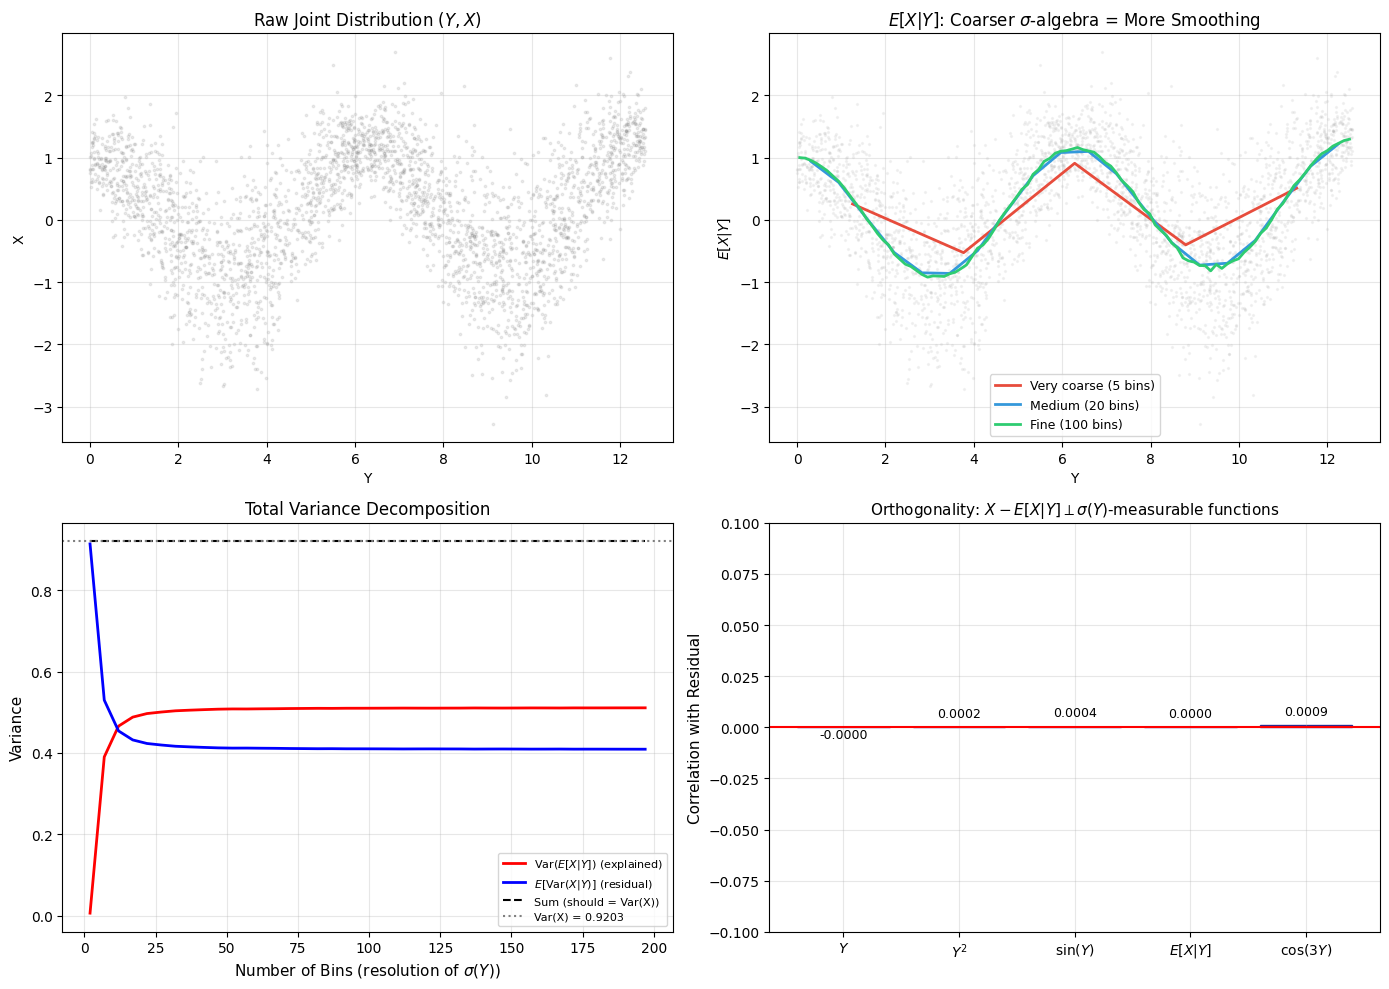

Total Var(X) = 0.92027
Var(E[X|Y]) + E[Var(X|Y)] = 0.51102 + 0.40925 = 0.92027


In [6]:
np.random.seed(2024)
n = 100_000

# Generate data with heteroscedastic noise
Y_sm = np.random.uniform(0, 4 * np.pi, n)
noise_scale = 0.3 + 0.5 * np.abs(np.sin(Y_sm / 2))
X_sm = np.cos(Y_sm) + 0.3 * Y_sm / (4 * np.pi) + noise_scale * np.random.standard_normal(n)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Raw scatter
ax = axes[0, 0]
idx_sm = np.random.choice(n, 3000, replace=False)
ax.scatter(Y_sm[idx_sm], X_sm[idx_sm], alpha=0.15, s=3, color='gray')
ax.set_title('Raw Joint Distribution $(Y, X)$', fontsize=12)
ax.set_xlabel('Y'); ax.set_ylabel('X')
ax.grid(True, alpha=0.3)

# Panel 2: Smoothing at different resolutions
ax = axes[0, 1]
ax.scatter(Y_sm[idx_sm], X_sm[idx_sm], alpha=0.08, s=2, color='gray')
resolutions = [(5, '#e74c3c', 'Very coarse (5 bins)'),
               (20, '#3498db', 'Medium (20 bins)'),
               (100, '#2ecc71', 'Fine (100 bins)')]
for nb, color, label in resolutions:
    edges = np.linspace(0, 4 * np.pi, nb + 1)
    bidx = np.clip(np.digitize(Y_sm, edges) - 1, 0, nb - 1)
    bmeans = np.array([np.mean(X_sm[bidx == b]) if np.sum(bidx == b) > 0
                       else np.nan for b in range(nb)])
    centers = (edges[:-1] + edges[1:]) / 2
    valid = ~np.isnan(bmeans)
    ax.plot(centers[valid], bmeans[valid], color=color, linewidth=2, label=label)

ax.set_title('$E[X|Y]$: Coarser $\\sigma$-algebra = More Smoothing', fontsize=12)
ax.set_xlabel('Y'); ax.set_ylabel('$E[X|Y]$')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: Total variance decomposition
ax = axes[1, 0]
bin_list = np.arange(2, 202, 5)
var_ce = []  # Var(E[X|Y])
e_cv = []    # E[Var(X|Y)]

for nb in bin_list:
    edges = np.linspace(0, 4 * np.pi, nb + 1)
    bidx = np.clip(np.digitize(Y_sm, edges) - 1, 0, nb - 1)
    bmeans = np.array([np.mean(X_sm[bidx == b]) if np.sum(bidx == b) > 5
                       else np.nan for b in range(nb)])
    bvars = np.array([np.var(X_sm[bidx == b]) if np.sum(bidx == b) > 5
                      else np.nan for b in range(nb)])
    bcounts = np.array([np.sum(bidx == b) for b in range(nb)])
    valid = ~np.isnan(bmeans)
    # Var(E[X|Y]) and E[Var(X|Y)]
    ce_values = bmeans[valid]
    cv_values = bvars[valid]
    weights = bcounts[valid] / bcounts[valid].sum()
    var_ce.append(np.sum(weights * (ce_values - np.sum(weights * ce_values))**2))
    e_cv.append(np.sum(weights * cv_values))

total_var = np.var(X_sm)
ax.plot(bin_list, var_ce, 'r-', linewidth=2, label='$\mathrm{Var}(E[X|Y])$ (explained)')
ax.plot(bin_list, e_cv, 'b-', linewidth=2, label='$E[\mathrm{Var}(X|Y)]$ (residual)')
ax.plot(bin_list, np.array(var_ce) + np.array(e_cv), 'k--', linewidth=1.5,
        label='Sum (should = Var(X))')
ax.axhline(total_var, color='gray', linestyle=':', linewidth=1.5,
           label=f'Var(X) = {total_var:.4f}')
ax.set_xlabel('Number of Bins (resolution of $\\sigma(Y)$)', fontsize=11)
ax.set_ylabel('Variance', fontsize=11)
ax.set_title('Total Variance Decomposition', fontsize=12)
ax.legend(fontsize=8, loc='lower right')
ax.grid(True, alpha=0.3)

# Panel 4: Orthogonality of residual
ax = axes[1, 1]
n_bins_orth = 60
edges_o = np.linspace(0, 4 * np.pi, n_bins_orth + 1)
bidx_o = np.clip(np.digitize(Y_sm, edges_o) - 1, 0, n_bins_orth - 1)
bmeans_o = np.array([np.mean(X_sm[bidx_o == b]) for b in range(n_bins_orth)])
ce_all = bmeans_o[bidx_o]
residual = X_sm - ce_all

# Compute correlation between residual and several sigma(Y)-measurable functions
test_funcs = {
    '$Y$': Y_sm,
    '$Y^2$': Y_sm**2,
    '$\\sin(Y)$': np.sin(Y_sm),
    '$E[X|Y]$': ce_all,
    '$\\cos(3Y)$': np.cos(3 * Y_sm),
}

func_names = list(test_funcs.keys())
correlations = [np.corrcoef(residual, f)[0, 1] for f in test_funcs.values()]

bars = ax.bar(range(len(func_names)), correlations, color='steelblue',
              edgecolor='navy', alpha=0.8)
ax.set_xticks(range(len(func_names)))
ax.set_xticklabels(func_names, fontsize=10)
ax.set_ylabel('Correlation with Residual', fontsize=11)
ax.set_title('Orthogonality: $X - E[X|Y] \\perp \\sigma(Y)$-measurable functions', fontsize=11)
ax.axhline(0, color='red', linewidth=1.5)
ax.set_ylim(-0.1, 0.1)
ax.grid(True, alpha=0.3)
for i, v in enumerate(correlations):
    ax.text(i, v + 0.005 * np.sign(v), f'{v:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f'Total Var(X) = {total_var:.5f}')
print(f'Var(E[X|Y]) + E[Var(X|Y)] = {var_ce[-1]:.5f} + {e_cv[-1]:.5f} = {var_ce[-1]+e_cv[-1]:.5f}')

## Key Takeaways

1. **$L^2$ projection:** $E[X \mid Y]$ is the unique $\sigma(Y)$-measurable function minimizing $E[(X - g(Y))^2]$. No other function of $Y$ can predict $X$ more accurately in the mean-squared sense.

2. **Discrete case:** Computing $E[X \mid Y]$ reduces to averaging $X$ over each level set $\{Y = y\}$. The result is a function $g(y) = E[X \mid Y = y]$.

3. **Continuous case (binning):** For continuous $Y$, we partition its range into bins and average $X$ within each. Finer bins reduce bias but increase variance -- the classic bias-variance tradeoff.

4. **Tower property:** $E[E[X \mid Y]] = E[X]$ always holds. This is a direct consequence of the projection interpretation: projecting twice onto a larger then smaller subspace gives the same result as projecting onto the smaller one directly.

5. **Smoothing interpretation:** Coarser $\sigma$-algebras produce more smoothing (averaging over larger groups), while finer ones preserve more detail. In the limit, $\sigma(Y) = \sigma(X, Y)$ gives $E[X \mid X, Y] = X$ (no smoothing).

6. **Orthogonality:** The residual $X - E[X \mid Y]$ is orthogonal to all $\sigma(Y)$-measurable functions, which drives the total variance decomposition $\mathrm{Var}(X) = \mathrm{Var}(E[X \mid Y]) + E[\mathrm{Var}(X \mid Y)]$.